In [1]:
# Importar las librerias necesaria
import pandas as pd
import numpy as np
import os
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import Input, Dense, Dropout
import sklearn
from sklearn.metrics import confusion_matrix
from tensorflow import lite

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sn

In [304]:
# Nombre de los sensores empleados.
emg_columns = ["EMG1"]

# Asignar a cada carpeta un identificador correspondiente a una tarea motora.
FOLDER_2_LABEL = {"task1": 0, "task2": 1, "task4": 2}
#FOLDER_2_LABEL = {"task1": 0, "task2": 1, "task3": 2,"task4": 3}

# Frecuencia de Muestreo de la señal.
ORIGINAL_FREC = 100 # Hz
# Tiempo de muestreo de un sample.
SAMPLE_TIME = 3
TOTAL_DATA = int(SAMPLE_TIME*ORIGINAL_FREC)

# Path donde se almacenan los datos.
MAIN_PATH = "data_task_not3"

# Path para guardar las características calculadas.
FEATURES_PATH = "Features.csv"

In [305]:
def filter_signal(df: pd.DataFrame, window_size: int):
    """
    Filtrar la señal usando el método de la media móvil.
    Params:
        df: contiene los datos emg, siendo
            cada columna el registro de un
            sensor. 
        window_size: tamano de la ventana móvil.
    Return:
        df_filtered (Dataframe): contiene los datos EMG 
                                 filtrados por columna.
    """
    df_filtered = df.rolling(window_size).mean()
    df_filtered.dropna(inplace=True)
    return df_filtered

def normalize_columns(df: pd.DataFrame):
    """
    Normalizar las columnas aplicando el 
    método de normalización min-max.
    """
    df_normalized = (df-df.min())/(df.max()-df.min())
    return df_normalized

def calculate_features(df: pd.DataFrame, label: int):
    """
    Calcula las características de la señal por sensor,
    usando el método del valor RMS.
    Params:
        df: contiene los datos emg, siendo
            cada columna el registro de un
            sensor.
        label: el identificador de la tarea motora a
               la que corresponde esa señal.
    Return:
        features_list (list): contiene el label de la
                              señal y las características. 
    """
    features_list = []
    for sensor in emg_columns:
        for i in range(0, 300, 50):
            features_list.append(np.min(df.iloc[i:i+50][sensor]))#min
            features_list.append(np.max(df.iloc[i:i+50][sensor]))#max
            #features_list.append(np.sqrt(np.mean(df.iloc[i:i+50][sensor]**2)))#RMS
        features_list.append(np.sqrt(np.mean(df.iloc[::][sensor]**2)))#RMS GLOBAL
    features_list.insert(0, label)
    return features_list
    

In [306]:
# El tamano de la ventana para calcular las características.
WINDOW_RMS = 50

# El tamano de la ventana inicial debe ser divisible para el tamano de la ventana RMS.
assert(TOTAL_DATA % WINDOW_RMS == 0)

# Generar una lista que contenga los nombres de las características a calcular.
#indice = ['Min','Max','RMS']
indice = ['Min','Max']
features_column = [i + '_'  + str(x) + '_' + sensor for sensor in emg_columns for x in range(WINDOW_RMS,TOTAL_DATA+WINDOW_RMS, WINDOW_RMS) for i in indice]
features_column.insert(len(features_column),"RMS")
features_column.insert(0,"Label")
print(features_column)
# Inicializar el Dataframe que contendrá las características calculadas más adelante.
df_features = pd.DataFrame(columns=features_column)
print(df_features)
# Recorrer cada carpeta.
for folder in os.listdir(MAIN_PATH):
    folder_path = os.path.join(MAIN_PATH, folder)
    # Recorrer cada archivo de la carpeta.
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        # Leer las senales EMG.
        df = pd.read_csv(file_path, names=emg_columns, index_col=False)
        # Filtrar las senales EMG.
        df_filtered = filter_signal(df, 2)
        # Normalizar las senales EMG.
        df_norm = normalize_columns(df_filtered)
        # Calcular las características del respectivo archivo.
        features = calculate_features(df_norm, FOLDER_2_LABEL[folder])
        # Agregar las características calculadas al Dataframe df_features.
        print(len(df_features))
        df_features.loc[len(df_features)] = features

['Label', 'Min_50_EMG1', 'Max_50_EMG1', 'Min_100_EMG1', 'Max_100_EMG1', 'Min_150_EMG1', 'Max_150_EMG1', 'Min_200_EMG1', 'Max_200_EMG1', 'Min_250_EMG1', 'Max_250_EMG1', 'Min_300_EMG1', 'Max_300_EMG1', 'RMS']
Empty DataFrame
Columns: [Label, Min_50_EMG1, Max_50_EMG1, Min_100_EMG1, Max_100_EMG1, Min_150_EMG1, Max_150_EMG1, Min_200_EMG1, Max_200_EMG1, Min_250_EMG1, Max_250_EMG1, Min_300_EMG1, Max_300_EMG1, RMS]
Index: []
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [307]:

df_features
#df_features['Label']


,Label,Min_50_EMG1,Max_50_EMG1,Min_100_EMG1,Max_100_EMG1,Min_150_EMG1,Max_150_EMG1,Min_200_EMG1,Max_200_EMG1,Min_250_EMG1,Max_250_EMG1,Min_300_EMG1,Max_300_EMG1,RMS
0,0.0,0.004651,0.911628,0.000000,0.855814,0.004651,0.786047,0.111628,0.832558,0.255814,1.000000,0.213953,0.865116,0.545831
1,0.0,0.194872,0.994872,0.102564,0.989744,0.010256,1.000000,0.112821,0.835897,0.117949,0.825641,0.000000,0.728205,0.537942
2,0.0,0.268293,0.963415,0.000000,1.000000,0.103659,0.975610,0.164634,0.981707,0.128049,0.914634,0.231707,0.878049,0.653096
3,0.0,0.033175,0.767773,0.085308,1.000000,0.080569,0.829384,0.085308,0.829384,0.037915,0.791469,0.000000,0.810427,0.444952
4,0.0,0.000000,0.953757,0.144509,1.000000,0.202312,0.872832,0.150289,0.768786,0.173410,0.855491,0.104046,0.878613,0.498708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2.0,0.478122,0.555318,0.000000,1.000000,0.456777,0.548915,0.190324,0.674493,0.259338,0.764497,0.266453,0.919602,0.518553
146,2.0,0.543661,0.625137,0.336134,0.959445,0.528681,0.645232,0.000000,0.835952,0.499087,0.628791,0.200585,1.000000,0.577276
147,2.0,0.502274,0.596766,0.000000,1.000000,0.062658,0.817079,0.049015,0.764528,0.467408,0.638201,0.491662,0.643759,0.564533
148,2.0,0.652378,0.719357,0.243470,0.963496,0.645680,0.725720,0.000000,1.000000,0.650368,0.738111,0.264568,0.966510,0.684385


In [308]:
# Escribir el Dataframe con las características.
df_features.to_csv(FEATURES_PATH, index=False)

In [309]:
# Definir una semilla.
RANDOM_STATE = 42

# Establecer el porcentaje para dividir la data.
TRAIN_SPLIT = 0.6
VALID_TEST_SPLIT = 0.2
assert(TRAIN_SPLIT + (2*VALID_TEST_SPLIT) == 1)

# Definir la taza de aprendizaje.
LEARNING_RATE = 0.01#0.001

# Definir el número de épocas.
EPOCHS = 200

# Definir el tamaño del batch.
BATCH_SIZE = 64

In [310]:
# Leer archivo con características de las señales EMG.
features_df = pd.read_csv(FEATURES_PATH)
features_df.head()


,Label,Min_50_EMG1,Max_50_EMG1,Min_100_EMG1,Max_100_EMG1,Min_150_EMG1,Max_150_EMG1,Min_200_EMG1,Max_200_EMG1,Min_250_EMG1,Max_250_EMG1,Min_300_EMG1,Max_300_EMG1,RMS
0,0.0,0.004651,0.911628,0.000000,0.855814,0.004651,0.786047,0.111628,0.832558,0.255814,1.000000,0.213953,0.865116,0.545831
1,0.0,0.194872,0.994872,0.102564,0.989744,0.010256,1.000000,0.112821,0.835897,0.117949,0.825641,0.000000,0.728205,0.537942
2,0.0,0.268293,0.963415,0.000000,1.000000,0.103659,0.975610,0.164634,0.981707,0.128049,0.914634,0.231707,0.878049,0.653096
3,0.0,0.033175,0.767773,0.085308,1.000000,0.080569,0.829384,0.085308,0.829384,0.037915,0.791469,0.000000,0.810427,0.444952
4,0.0,0.000000,0.953757,0.144509,1.000000,0.202312,0.872832,0.150289,0.768786,0.173410,0.855491,0.104046,0.878613,0.498708


In [311]:
# Convertir la columna a tipo int.
features_df["Label"] = features_df["Label"].astype(int)
# Asegurarnos de no introducir datos vacíos.
features_df.dropna(inplace=True)
# Hacer un shuffle a los datos.
features = features_df.sample(frac=1, random_state=RANDOM_STATE)
# Convertir a un arreglo de numpy (ya que el modelo trabaja con este tipo de datos).
features = features.to_numpy()
print(features)
# Separar los datos entre el target (el id de la tarea motora) y las características.
# Nota: En este caso en específico se usa la función to_categorical, ya que 
# la función de pérdida que se usó en el modelo requiere de variables categóricas.
y_values = keras.utils.to_categorical(features[:,0], num_classes=3)###numero de clases
x_values = features[:,1:].astype('float32')
print(y_values)
print(features.shape)

# Separar los datos en TRAINING, TESTING Y VALIDATION.
TRAIN_SPLIT =  int(TRAIN_SPLIT * features.shape[0])
TEST_SPLIT = int(VALID_TEST_SPLIT * features.shape[0] + TRAIN_SPLIT)
print(TRAIN_SPLIT)
print(TEST_SPLIT)
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])
print(x_validate,x_test)
# Asegurar que la división de los datos fue exitosa.
assert(x_train.shape[0] + x_test.shape[0] + x_validate.shape[0] == features.shape[0])

[[1.         0.09798995 0.76130653 ... 0.12562814 0.78894472 0.48340557]
 [0.         0.11111111 0.74879227 ... 0.         0.77777778 0.5176092 ]
 [2.         0.40858896 0.5607362  ... 0.43312883 0.54969325 0.49777857]
 ...
 [0.         0.05050505 0.83333333 ... 0.15656566 0.78282828 0.5293105 ]
 [1.         0.39417476 0.6407767  ... 0.34757282 0.69514563 0.54629982]
 [2.         0.27657143 0.416      ... 0.256      0.41942857 0.35539804]]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0.

In [312]:
# Definir la arquitectura del modelo
model = Sequential()
model.add(Dense(60, input_shape = (x_train.shape[1],), activation='relu'))#60
model.add(Dropout(0.2))
model.add(Dense(30, input_shape = (x_train.shape[1],),activation='relu'))#30
model.add(Dropout(0.2))
model.add(Dense(10,activation='relu'))#10
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))


In [313]:
# Definir la función de optimización y sus hiperparámetros.
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
# Definir la función de pérdida y compilar el modelo.
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# Entrenar el modelo
start = time.time()
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                            validation_data=(x_validate, y_validate))
stop = time.time()
print(f"Total training time: {stop - start}s")
test_results = model.evaluate(x_test, y_test, verbose=1)

Epoch 1/200
2/2 [==============================] - 1s 215ms/step - loss: 1.1466 - accuracy: 0.2556 - recall_30: 0.0000e+00 - precision_30: 0.0000e+00 - val_loss: 1.0655 - val_accuracy: 0.3667 - val_recall_30: 0.0000e+00 - val_precision_30: 0.0000e+00
Epoch 2/200
2/2 [==============================] - 0s 18ms/step - loss: 1.0990 - accuracy: 0.3667 - recall_30: 0.0000e+00 - precision_30: 0.0000e+00 - val_loss: 1.0672 - val_accuracy: 0.5667 - val_recall_30: 0.0000e+00 - val_precision_30: 0.0000e+00
Epoch 3/200
2/2 [==============================] - 0s 19ms/step - loss: 1.0750 - accuracy: 0.3889 - recall_30: 0.0000e+00 - precision_30: 0.0000e+00 - val_loss: 1.0689 - val_accuracy: 0.5000 - val_recall_30: 0.0000e+00 - val_precision_30: 0.0000e+00
Epoch 4/200
2/2 [==============================] - 0s 19ms/step - loss: 1.0546 - accuracy: 0.4889 - recall_30: 0.0000e+00 - precision_30: 0.0000e+00 - val_loss: 1.0881 - val_accuracy: 0.3333 - val_recall_30: 0.0000e+00 - val_precision_30: 0.0000e+00

In [314]:
#results = model.evaluate(x_test, y_test, verbose=1)
print(f"Model accuracy: {test_results[1]*100} %")
#print(history.history)

Model accuracy: 80.0000011920929 %


Text(0.5, 1.0, 'Train Recall')

<Figure size 1440x1440 with 0 Axes>

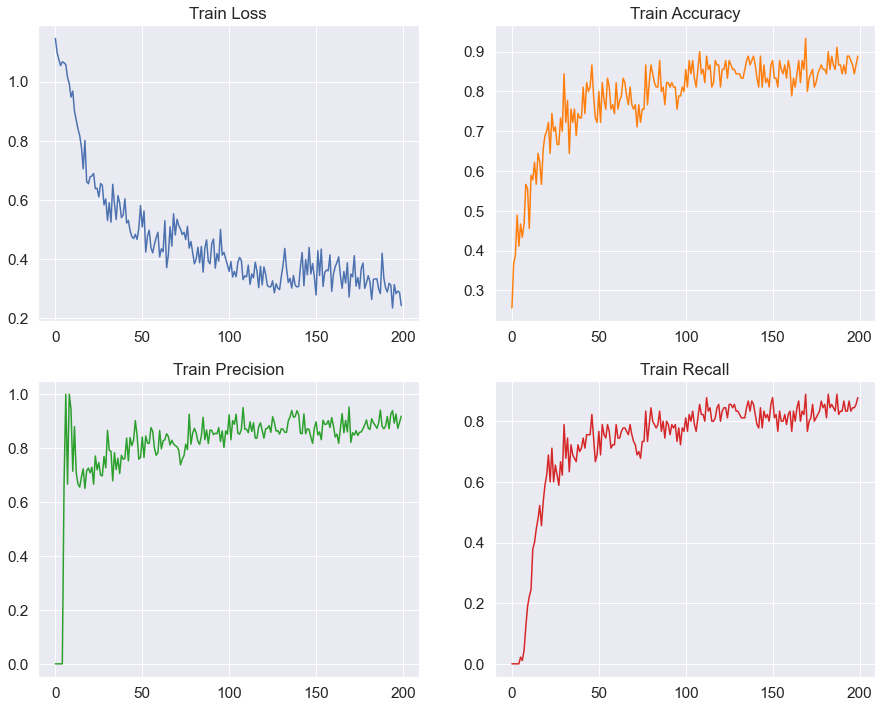

In [316]:
x = [i for i in range (0,len(history.history["loss"]))]

plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 2, figsize=(15,12))
axs[0, 0].plot(x, history.history["loss"])
axs[0, 0].set_title('Train Loss')
axs[0, 1].plot(x, history.history["accuracy"], 'tab:orange')
axs[0, 1].set_title('Train Accuracy')
axs[1, 0].plot(x, history.history["precision_30"], 'tab:green')
axs[1, 0].set_title('Train Precision')
axs[1, 1].plot(x, history.history["recall_30"], 'tab:red')
axs[1, 1].set_title('Train Recall')

1/1 [==============================] - 0s 13ms/step


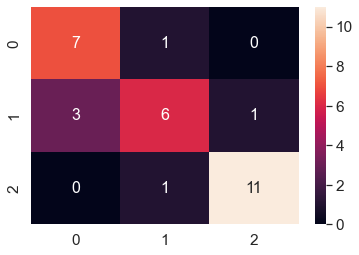

In [318]:
# Testear el modelo
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test, axis=-1)

# Definir la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

plt.show()

In [319]:
# Definir la dirección donde se guardará los datos del modelo.
MODELS_DIR = 'models/'
MODEL_TFLITE = MODELS_DIR + 'model_no_quant.tflite'

# Crear la carpeta sino existe.
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

# Guardar el modelo.
model.save(MODELS_DIR)

# Convertir el modelo a Tensorflow Lite.
converter = lite.TFLiteConverter.from_keras_model(model)
model_tflite = converter.convert()

# Guardar el modelo .tflite
open(MODEL_TFLITE, "wb").write(model_tflite)

# Correr esta linea de código en Linux.
# Esto se hace para transformar el modelo a un archivo fuente C (https://www.tensorflow.org/lite/microcontrollers/build_convert?hl=es-419#model_conversion)
# xxd -i converted_model.tflite > model_data.cc

INFO:tensorflow:Assets written to: models/assets
INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp0mjdc9dd\assets


14584